<a href="https://colab.research.google.com/github/alhichri/RS-DeepSuperLearner/blob/main/Split_datsets_into_folds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_efficientnets
!pip install keras_applications

import keras_efficientnets 
from keras_efficientnets import efficientnet
from keras_efficientnets.custom_objects import Swish

     |████████████████████████████████| 51kB 7.3MB/s 


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
!python -V

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import itertools
import seaborn as sn
import time
from sklearn.metrics import confusion_matrix,  classification_report, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle
#from tensorflow.keras import layers
# from tensorflow import keras 

import tensorflow as tf
tf.random.set_seed(1)

# from tensorflow import set_random_seed
# set_random_seed(1)
from tensorflow.python.keras import backend as k   # added
from tensorflow.keras import utils as np_utils   #added


from tensorflow.keras.applications import inception_v3,inception_resnet_v2, densenet, vgg16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping , ModelCheckpoint
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions



#from keras_efficientnets.optimize

from google.colab import drive
drive.mount('/content/gdrive' , force_remount=True)

print(tf.__version__)

Python 3.6.9
Mounted at /content/gdrive
2.4.1


In [ ]:
from importlib.machinery import SourceFileLoader
somemodule = SourceFileLoader('squeezenet', '/content/gdrive/My Drive/utils/squeezenet.py').load_module()
#somemodule = SourceFileLoader('squeezenet', '/content/gdrive/My Drive/students/ruwaida_alharbi/colab_folder/utils/squeezenet.py').load_module()
from squeezenet import SqueezeNet
#DNet1 = SqueezeNet(input_shape=img_dim, include_top=True,weights='imagenet')

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

 
    
def plot_confusion_matrix2(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() +1).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def my_random_split(class_indeces , num_classes, trainSize):
            train_samples = np.zeros((2,1));         test_samples = np.zeros((2,1));
            for i in range(num_classes):
                class_size = np.sum(class_indeces[1,:] == i)
                idx = np.nonzero(class_indeces[1,:] == i)
                curr_class_idx   = class_indeces[0,idx]
                corresponding_labels = class_indeces[1,idx]
                indeces_permuted = np.vstack((  np.random.permutation(curr_class_idx[0])   , corresponding_labels[0]))
                samplesFraction = int(np.round(class_size * trainSize/100 ))
                train_indeces = indeces_permuted[:,0:samplesFraction]
                test_indeces = indeces_permuted[:,samplesFraction:]
                train_samples = np.hstack((train_samples, train_indeces))
                test_samples = np.hstack((test_samples, test_indeces))
            train_samples = train_samples.astype(int)
            test_samples = test_samples.astype(int)
            train_samples = train_samples[:,1:]
            test_samples = test_samples[:,1:]
    
            return train_samples, test_samples


def split_into_folds(class_indeces , num_classes, n_folds):
            fold_splits_indeces = [] ;  fold_splits_labels = [] 
            for f in range(n_folds):
                fold_splits_indeces.append([])
                fold_splits_labels.append([])
                
                
            for i in range(num_classes):
                class_size = np.sum(class_indeces[1,:] == i)
                idx = np.nonzero(class_indeces[1,:] == i)
                curr_class_idx   = class_indeces[0,idx]
                corresponding_labels = class_indeces[1,idx]
                indeces_permuted = np.vstack((  np.random.permutation(curr_class_idx[0])   , corresponding_labels[0]))
                samplesFraction = int(np.round(class_size / n_folds ))
                for f in range(n_folds-1):
                    fold_splits_indeces[f] = np.hstack( (  fold_splits_indeces[f]  ,   indeces_permuted[0,f*samplesFraction:(f+1)*samplesFraction]  )   )
                    fold_splits_labels[f] = np.hstack( (  fold_splits_labels[f]  ,   indeces_permuted[1,f*samplesFraction:(f+1)*samplesFraction]  )   )
                f=f+1; 
                fold_splits_indeces[f] = np.hstack( (  fold_splits_indeces[f]  ,   indeces_permuted[0,-samplesFraction:]  )   )
                fold_splits_labels[f] = np.hstack( (  fold_splits_labels[f]  ,   indeces_permuted[1,-samplesFraction:]  )   )
  
            for f in range(n_folds):
                fold_splits_indeces[f]  = fold_splits_indeces[f].astype(int)
                fold_splits_labels[f]   = fold_splits_labels[f].astype(int)  

            fold_splits_indeces = np.asarray(fold_splits_indeces)
            fold_splits_labels = np.asarray(fold_splits_labels)

            return fold_splits_indeces , fold_splits_labels





In [ ]:
def build_and_train_densenet(img_dim, num_classes , X_train, Y_train):
  
    layer_name1 = 'pool4_conv'  # index = -116
    layer_name2 = 'relu'        # index = -1
    DNet = densenet.DenseNet121(input_shape=img_dim, include_top=False, weights='imagenet', input_tensor=None, 
                                pooling=None, classes=1000)
    #DNet.summary()
    Net_layers=len(DNet.layers)
    DNet.trainable=True
    #for layer in range(Net_layers):
    # for layer in range(Net_layers-31):
    #       DNet.layers[layer].trainable = False
  
    xx1 = tf.keras.layers.Conv2D(128, 3, strides=2)(DNet.get_layer(index=-116).output)
    xx1=tf.keras.layers.BatchNormalization()(xx1)
    xx1 = tf.keras.layers.Activation('relu')(xx1)

    #xx1 = Swish()(xx1)
    xx1 = tf.keras.layers.GlobalAveragePooling2D(name='fea_out1')(xx1)
    xx1 = tf.keras.layers.Dropout(0.8)(xx1)
    output1 = tf.keras.layers.Dense(num_classes, activation='linear')(xx1)
    output1=tf.keras.layers.Activation('softmax')(output1)

    #print(DNet.output)
    xx2 = tf.keras.layers.GlobalAveragePooling2D(name='fea_out2')(DNet.get_layer(index=-1).output)
    output2 = tf.keras.layers.Dense(num_classes, activation='softmax')(xx2)
    DenseNetModel =tf.keras.Model(inputs=DNet.input, outputs=[output1,output2])
#######################################################################################################
    learningRate = 0.001; epochs = 20; batch_size = 32
    # DenseNetModel.summary()
    #raise ValueError("Script End")
    ######### Model with auxiliary classification loss........
    DenseNetModel.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
    #DenseNettModel.summary()
    history_DenseNetModel1 = DenseNetModel.fit(X_train, [Y_train,Y_train], batch_size=batch_size, epochs=20, verbose=1, shuffle = True)
    learningRate = learningRate*0.1
    DenseNetModel.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
    history_DenseNetModel2 = DenseNetModel.fit(X_train, [Y_train,Y_train], batch_size=batch_size, epochs=20, verbose=1, shuffle = True)
    mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    learningRate = learningRate*0.1
    DenseNetModel.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
    history_DenseNetModel3 = DenseNetModel.fit(X_train, [Y_train,Y_train], batch_size=batch_size, epochs=20, verbose=1, shuffle = True, callbacks=[es])
#######################################################################################################
    return DenseNetModel, history_DenseNetModel1


def build_and_train_efficientnetB3(img_dim, num_classes , X_train, Y_train):
    inputs1 = tf.keras.layers.Input(shape=(16, 16, 816))
    inputs2 = tf.keras.layers.Input(shape=(8, 8, 1536))
    layer_index1 = -119   # 'swish_54'
    layer_index2 = -1   # 'swish_78'
    DNet = efficientnet.EfficientNetB3(input_shape=img_dim, classes=1000, include_top=False, weights='imagenet')
    Net_layers=len(DNet.layers)
    DNet.trainable=True
    # for layer in range(Net_layers-3):
    #       DNet.layers[layer].trainable = False
    #DNet.summary()
    xx1 = keras_efficientnets.custom_objects.layers.Conv2D(128, 3, strides=2)(DNet.get_layer(index=layer_index1).output)
    xx1=keras_efficientnets.custom_objects.layers.BatchNormalization()(xx1)
    #xx1 = Activation('relu')(xx1)
    xx1=Swish()(xx1)
    xx1 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out1')(xx1)
    xx1 = keras_efficientnets.custom_objects.layers.Dropout(0.8)(xx1)
    output1 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='linear')(xx1)
    output1=keras_efficientnets.custom_objects.layers.Activation('softmax')(output1)
    #print(DNet.output)
    xx2 = keras_efficientnets.custom_objects.layers.GlobalAveragePooling2D(name='fea_out2')(DNet.get_layer(index=layer_index2).output)
    output2 = keras_efficientnets.custom_objects.layers.Dense(num_classes, activation='softmax')(xx2)
    ######### Model with auxiliary classification loss........
    efficientModel =keras_efficientnets.efficientnet.Model(inputs=DNet.input, outputs=[output1,output2])
    #efficientModel.summary()
#######################################################################################################
    learningRate = 0.001; epochs = 5; batch_size = 32
    # efficientModel.summary()
    #raise ValueError("Script End")
    ######### Model with auxiliary classification loss........ 
    efficientModel.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
    #DenseNettModel.summary()
    history_efficientModel1 = efficientModel.fit(X_train, [Y_train,Y_train], batch_size=batch_size, epochs=20, verbose=1,  shuffle = True)
    learningRate = learningRate*0.1
    efficientModel.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
    history_efficientModel2 = efficientModel.fit(X_train, [Y_train,Y_train], batch_size=batch_size,  epochs=20,  verbose=1,  shuffle = True)
    mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    learningRate = learningRate*0.1
    efficientModel.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate),metrics=['accuracy'])
    history_efficientModel2 = efficientModel.fit(X_train, [Y_train,Y_train], batch_size=batch_size,  epochs=20,  verbose=1,  shuffle = True, callbacks=[es])
#######################################################################################################
    return efficientModel, history_efficientModel1



def build_and_train_InceptionV3(img_dim, num_classes , X_train, Y_train):
    DNet=inception_v3.InceptionV3(input_shape=img_dim,include_top=False,weights='imagenet',input_tensor=None,pooling=None,classes=1000)
    layer_name1='mixed7'  # index = -83
    layer_name2='mixed10'   # index = -1
    #DNet1.summary()
    DNet.trainable=True
    xx1 = tf.keras.layers.Conv2D(128, 3, strides=2)(DNet.get_layer(index=-83).output)
    xx1=tf.keras.layers.BatchNormalization()(xx1)
    xx1 = tf.keras.layers.Activation('relu')(xx1)

    #xx1 = Swish()(xx1)
    xx1 = tf.keras.layers.GlobalAveragePooling2D(name='fea_out1')(xx1)
    xx1 = tf.keras.layers.Dropout(0.8)(xx1)
    output1 = tf.keras.layers.Dense(num_classes, activation='linear')(xx1)
    output1=tf.keras.layers.Activation('softmax')(output1)

    #print(DNet.output)
    xx2 = tf.keras.layers.GlobalAveragePooling2D(name='fea_out2')(DNet.get_layer(index=-1).output)
    output2 = tf.keras.layers.Dense(num_classes, activation='softmax')(xx2)
    InceptionV3Model =tf.keras.Model(inputs=DNet.input, outputs=[output1,output2])

#######################################################################################################
    learningRate = 0.001; epochs = 5; batch_size = 32
    # InceptionV3Model.summary()
    #raise ValueError("Script End")
    ######### Model with auxiliary classification loss........ 
    InceptionV3Model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    #DenseNettModel.summary()
    history_InceptionV3Model1 = InceptionV3Model.fit(X_train, [Y_train,Y_train], batch_size=batch_size, epochs=20, verbose=1,  shuffle = True)
    learningRate = learningRate*0.1
    InceptionV3Model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    history_InceptionV3Model2 = InceptionV3Model.fit(X_train, [Y_train,Y_train], batch_size=batch_size,  epochs=20,  verbose=1,  shuffle = True)
    mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    learningRate = learningRate*0.1
    InceptionV3Model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    history_InceptionV3Model3 = InceptionV3Model.fit(X_train, [Y_train,Y_train], batch_size=batch_size,  epochs=20,  verbose=1,  shuffle = True, callbacks=[es])
#######################################################################################################

    return InceptionV3Model , history_InceptionV3Model1
    

def build_and_train_Inception_resnet_v2(img_dim, num_classes , X_train, Y_train):
    DNet = inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=None,
                                      input_shape=img_dim, pooling=None, classes=1000)
    layer_name1='block17_20_ac'   # index = 594 
    layer_name2='conv_7b_ac'     # index = 779
    #DNet1.summary()
    DNet.trainable=True
    # xx1 = tf.keras.layers.Conv2D(128, 3, strides=2)(DNet.get_layer(index=-83).output)
    xx1 = tf.keras.layers.Conv2D(128, 3, strides=2)(DNet.get_layer(index=594).output)
    xx1=tf.keras.layers.BatchNormalization()(xx1)
    xx1 = tf.keras.layers.Activation('relu')(xx1)

    #xx1 = Swish()(xx1)
    xx1 = tf.keras.layers.GlobalAveragePooling2D(name='fea_out1')(xx1)
    xx1 = tf.keras.layers.Dropout(0.8)(xx1)
    output1 = tf.keras.layers.Dense(num_classes, activation='linear')(xx1)
    output1=tf.keras.layers.Activation('softmax')(output1)

    #print(DNet.output)
    xx2 = tf.keras.layers.GlobalAveragePooling2D(name='fea_out2')(DNet.get_layer(index=779).output)
    output2 = tf.keras.layers.Dense(num_classes, activation='softmax')(xx2)
    Inception_resnet_v2Model =tf.keras.Model(inputs=DNet.input, outputs=[output1,output2])

#######################################################################################################
    learningRate = 0.001; epochs = 5; batch_size = 32
    # Inception_resnet_v2Model.summary()
    #raise ValueError("Script End")
    ######### Model with auxiliary classification loss........ 
    Inception_resnet_v2Model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    #DenseNettModel.summary()
    history1 = Inception_resnet_v2Model.fit(X_train, [Y_train,Y_train], batch_size=batch_size, epochs=20, verbose=1,  shuffle = True)
    learningRate = learningRate*0.1
    Inception_resnet_v2Model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    history2 = Inception_resnet_v2Model.fit(X_train, [Y_train,Y_train], batch_size=batch_size,  epochs=20,  verbose=1,  shuffle = True)
    mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    learningRate = learningRate*0.1
    Inception_resnet_v2Model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    history3 = Inception_resnet_v2Model.fit(X_train, [Y_train,Y_train], batch_size=batch_size,  epochs=20,  verbose=1,  shuffle = True, callbacks=[es])
#######################################################################################################

    return Inception_resnet_v2Model , history1
    

def build_and_train_VGG16(img_dim, num_classes , X_train, Y_train):
    DNet = vgg16.VGG16(input_shape=img_dim,include_top=False, weights='imagenet', classes=1000)
    DNet.trainable=True
    #DNet1.summary()

    Net_layers=len(DNet.layers)
    for layer in range(Net_layers-2):
          DNet.layers[layer].trainable = False
    x = DNet.get_layer(index = -2).output
    #x = BatchNormalization()(feature_tensor)
    feature_tensor = tf.keras.layers.GlobalAveragePooling2D(name='branch1_02')(x)
    x = tf.keras.layers.Dense(128)(feature_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    last_layer = tf.keras.layers.LeakyReLU(0.5)(x)
    classifier2 = tf.keras.layers.Dense(num_classes, activation='softmax')(last_layer)
    VGG16_Model = tf.keras.Model(inputs=DNet.inputs, outputs=classifier2)

    # non working model
    # xx2 = tf.keras.layers.GlobalAveragePooling2D(name='fea_out2')(DNet.get_layer(index=-1).output)
    # output2 = tf.keras.layers.Dense(num_classes, activation='softmax')(xx2)
    # VGG16_Model =tf.keras.Model(inputs=DNet.input, outputs=output2)

#######################################################################################################
    learningRate = 0.001; epochs = 5; batch_size = 32
    # VGG16_Model.summary()
    #raise ValueError("Script End")
    ######### Model with auxiliary classification loss........ 
    VGG16_Model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    #DenseNettModel.summary()
    history1 = VGG16_Model.fit(X_train, Y_train, batch_size=batch_size, epochs=20, verbose=1,  shuffle = True)
    learningRate = learningRate*0.1
    VGG16_Model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    history2 = VGG16_Model.fit(X_train, Y_train, batch_size=batch_size,  epochs=20,  verbose=1,  shuffle = True)
    mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    learningRate = learningRate*0.1
    VGG16_Model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    history3 = VGG16_Model.fit(X_train, Y_train, batch_size=batch_size,  epochs=20,  verbose=1,  shuffle = True, callbacks=[es])
#######################################################################################################

    return VGG16_Model , history1

def build_VGG16_model(img_dim , num_classes, learningRate):
    DNet3=vgg16.VGG16(input_shape=img_dim,include_top=False, weights='imagenet', classes=1000)
    #DNet3.summary()
    Net_layers=len(DNet3.layers)
    DNet3.trainable=False
    for layer in range(Net_layers-2):
          DNet3.layers[layer].trainable = False
    x = DNet3.get_layer(index = -2).output
    #x = BatchNormalization()(feature_tensor)
    feature_tensor = tf.keras.layers.GlobalAveragePooling2D(name='branch1_02')(x)
    x = tf.keras.layers.Dense(128)(feature_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    last_layer = tf.keras.layers.LeakyReLU(0.5)(x)
    classifier2 = tf.keras.layers.Dense(num_classes, activation='softmax')(last_layer)
    VGG16Model = tf.keras.Model(inputs=DNet3.inputs, outputs=classifier2)
    VGG16Model.compile(loss=['categorical_crossentropy'], optimizer = tf.keras.optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    #VGG16Model.summary()
    return VGG16Model


def build_squeezeNet_model(img_dim, num_classes , learningRate):
    #Xtrain_task1 = InceptionV3.preprocess_input(Xtest_task1.astype(np.float32))
    #Xtrain_task1 = preprocess_input(np.float64(Xtrain_task1))
    DNet1 = SqueezeNet(input_shape=img_dim, include_top=True,weights='imagenet')
    #DNet1.summary()
    DNet1.trainable=True
    layer_name = 'fire9/concat'
    x = DNet1.get_layer(layer_name).output
    x = tf.keras.layers.Conv2D(filters=256 , kernel_size=(1,1) , strides=(1,1))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    lastLayer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)       
    SqeezenetModel = tf.keras.Model(inputs=DNet1.inputs, outputs=lastLayer)
    #SqeezenetModel.summary()
    #raise ValueError("Script End")
    #model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    SqeezenetModel.compile(loss='categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(lr=learningRate) ,metrics=['accuracy'])

    return SqeezenetModel    
    

In [ ]:
# # #  load data that is split into trainSet(10 folds) and testSet
# path_of_train_splits = '/content/gdrive/My Drive/RS_datasets_mat_files/WHU-RS19/train_splits_10_folds.npz'

# print("Loading training splits to disk: ", path_of_train_splits)
# D = np.load(path_of_train_splits)
# fold_splits_indeces = D['fold_splits_indeces']; fold_splits_labels = D['fold_splits_labels']; 
# print(fold_splits_indeces.shape)
# print(fold_splits_labels.shape)


# for i in range(fold_splits_indeces.shape[0]):
#     print(fold_splits_indeces[i,0:10])
#     # print(fold_splits_indeces)
#     # print(fold_splits_labels)        


In [ ]:
###################################################################################################
########################## Parameters:  ##########################
#path0 = '/content/gdrive/My Drive/remote_sensing_scene_datasets/' # change this base path to suit your environment
#path0 = '/content/gdrive/My Drive/RS_datasets_mat_files/' # change this base path to suit your environment
path0 = 'D:\\data\\Remote_sensing\\'
#path0 = '/content/gdrive/My Drive/remote_sensing_scene_datasets/' # change this base path to suit your environment
path0 = '/content/gdrive/My Drive/RS_datasets/RS_datasets_mat_files/' # change this base path to suit your environment

dataset=1
trainSize = 50
fname_of_train_splits =  'train_splits_10_folds.npz' 
folds_list = np.asarray([0,1,2,3,4,5,6,7,8,9])
training_folds =  folds_list[            :int(trainSize/10)   ]
testing_folds = folds_list[            int(trainSize/10):  ]
###################################################################################################
###################################################################################################

dataset_OA = [] ;     dataset_time = []; OA = np.zeros((5,5)); times_arr = np.zeros(5)

if dataset==0:
    dataset_path = path0 + 'UC_Merced/'
    prefix = 'Merced_'  # file names prefix
    mat = scipy.io.loadmat(dataset_path+'Merced_256x256.mat')
    X = mat['X']; y = mat['y']; num_classes = int(y.max()); print(num_classes)
    y = np.squeeze(y-1)
    num_samples = len(y)

elif dataset==1:
    dataset_path = path0 + 'KSA/'
    prefix = 'Merced_'  # file names prefix
    mat = scipy.io.loadmat(dataset_path+'KSA_256x256.mat')
    X = mat['X']; y = mat['y']; num_classes = int(y.max()); print(num_classes)
    y = np.squeeze(y-1)
    num_samples = len(y)
elif dataset == 2:
    dataset_path = path0 + 'RSSCN7/'
    prefix = 'RSSCN7_'  # file names prefix
    mat = scipy.io.loadmat(dataset_path+'RSSCN7.mat')
    X = mat['X']; y = mat['y']; num_classes = int(y.max()+1); print('num_classes' , num_classes)
    y = np.squeeze(y)
    num_samples = len(y)
elif dataset == 3:
    dataset_path = path0 + 'Optimal31/'
    prefix = 'AID_'  # file names prefix
    mat = scipy.io.loadmat(dataset_path+'Optimal31.mat')
    X = mat['X']; y = mat['y']; num_classes = int(y.max()); print(num_classes)
    y = np.squeeze(y-1)
    num_samples = len(y)
elif dataset == 4:
    dataset_path = path0 + 'WHU-RS19/'
    prefix = 'AID_'  # file names prefix
    mat = scipy.io.loadmat(dataset_path+'WHU-RS19.mat')
    X = mat['X']; y = mat['y']; num_classes = int(y.max())+1; print(num_classes)
    y = np.squeeze(y)
    num_samples = len(y)


print('Loaded dataset: ', dataset_path)
print('Dataset Size: ' , X.shape)
print('Number of classes: ' , num_classes)
print('trainSize: ' , trainSize)
print("training_folds:  ", training_folds)
print("testing_folds:  ", testing_folds)




img_rows, img_cols, img_channels = X[0].shape[0], X[0].shape[1], X[0].shape[2]
# Parameters for the DenseNet model builder
(img_channels, img_rows, img_cols) if tf.keras.backend.image_data_format() == 'channels_first' else (
img_rows, img_cols, img_channels)
img_dim = [img_rows,img_cols,img_channels]


13
Loaded dataset:  /content/gdrive/My Drive/RS_datasets/RS_datasets_mat_files/KSA/
Dataset Size:  (3250, 224, 224, 3)
Number of classes:  13
trainSize:  50
training_folds:   [0 1 2 3 4]
testing_folds:   [5 6 7 8 9]


In [ ]:


class_indeces = np.zeros((2,1));         
for i in range(num_classes):
    class_size = np.sum(y == i)
    idx = np.nonzero(y == i) 
    corresponding_labels = np.ones((class_size))*i
    indeces =  np.vstack(( idx  , corresponding_labels  ))
    class_indeces = np.hstack((class_indeces, indeces))
class_indeces = class_indeces[:,1:]
class_indeces = class_indeces.astype(int)

print('class_indeces: '  , class_indeces)


fold_splits_indeces, fold_splits_labels = split_into_folds(class_indeces , num_classes, n_folds=20)

print(fold_splits_indeces.shape)
print(fold_splits_labels.shape)


for i in range(fold_splits_indeces.shape[0]):
    print(fold_splits_indeces[i,0:10])
    # print(fold_splits_indeces)
    # print(fold_splits_labels)      


class_indeces:  [[   0    1    2 ... 3247 3248 3249]
 [   0    0    0 ...   12   12   12]]
(20, 156)
(20, 156)
[130 205  84  72 157 171 136 111  19 105]
[228  74  34  75  13  36 179  39  77  10]
[173 231 143 207 169 245  49 199 221 132]
[141 214 149 222  52 234  22  61 177 162]
[  1   2 153  46 243  79 193 244 180 201]
[213  96  18 115 148 138 212  85  32  91]
[ 70  53  29 114   3  41  48 128  54  64]
[233  88  67  35 144  40 191 224 118  71]
[196  23   7  55 200 208 174  25   9   5]
[ 38  93   4 242 182  94 232  65 127 170]
[122  68  16 237  95  60 156  97 113 194]
[142 247  43 192 109 249 120  66 189 230]
[ 73   6 248 236 165 152 211 163 131  83]
[216  11  24 160  76  90  80 116  27 159]
[ 17 195 134 106  59  81  20 108  44 227]
[ 47 246 124 133 139  31  63 135 172 210]
[ 26 181 235 117 147 206 125 238  42 217]
[  8 185  82 197 123 225  56 100 239 119]
[ 12 104 110 215  62  51 198 219 103 183]
[ 57 164 121  98 145  30  15  28 184 167]


In [ ]:

fname_with_path = dataset_path+'train_splits_20_folds.npz'
D = {'fold_splits_indeces': fold_splits_indeces, 'fold_splits_labels': fold_splits_labels}
np.savez(fname_with_path, **D)
print("Saved results to disk: ", fname_with_path)


Saved results to disk:  /content/gdrive/My Drive/RS_datasets/RS_datasets_mat_files/WHU-RS19/train_splits_20_folds.npz


In [ ]:
# #  load data that is split into trainSet(10 folds) and testSet
path_of_train_splits = dataset_path + fname_of_train_splits
print("Loading training splits to disk: ", path_of_train_splits)
D = np.load(path_of_train_splits)
fold_splits_indeces = D['fold_splits_indeces']; fold_splits_labels = D['fold_splits_labels']; 

print('Dataset Size: ' , X.shape)
print('Number of classes: ' , num_classes)
print('trainSize: ' , trainSize)

# find the number of classes in one fold
class_size = np.zeros((num_classes))
for i in range(num_classes):
    class_size[i] = np.sum(fold_splits_labels[0] == i)
print('class_size of one folds: ' , class_size)

def get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds):
  TT0 = []; TT1 = []
  for f in list_of_folds  :
      TT0 = np.hstack(( TT0 , fold_splits_indeces[f,:]   ))
      TT1 = np.hstack(( TT1 , fold_splits_labels[f,:]   ))
  train_samples = np.vstack(( TT0 , TT1   ))
  train_samples = train_samples.astype(int)
  return train_samples

split_location = int(  len(training_folds) /2     )
fold0_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=training_folds[ :split_location    ])
fold1_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=training_folds[ split_location:   ])
test_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=testing_folds)
print("fold0_samples  shape", fold0_samples.shape)
print("fold1_samples  shape", fold1_samples.shape)
print("test_samples  shape", test_samples.shape)

# load data divided into folds
X_fold0 =  X[fold0_samples[0]  ].copy()
y_fold0 =  y[fold0_samples[0]  ].copy()
X_fold1 =  X[fold1_samples[0]  ].copy()
y_fold1 =  y[fold1_samples[0]  ].copy()
X_test =  X[test_samples[0]  ].copy()
y_test =  y[test_samples[0]  ].copy()
print("X_fold0  shape", X_fold0.shape)
print("y_fold0  shape", y_fold0.shape)
print("X_fold1  shape", X_fold1.shape)
print("y_fold1  shape", y_fold1.shape)
print("X_test  shape", X_test.shape)
print("y_test  shape", y_test.shape)


for i in range(fold_splits_indeces.shape[0]):
    print(fold_splits_indeces[i,0:10])





Loading training splits to disk:  /content/gdrive/My Drive/RS_datasets/RS_datasets_mat_files/RSSCN7/train_splits_10_folds.npz
Dataset Size:  (2800, 256, 256, 3)
Number of classes:  7
trainSize:  50
class_size of one folds:  [40. 40. 40. 40. 40. 40. 40.]
fold0_samples  shape (2, 560)
fold1_samples  shape (2, 840)
test_samples  shape (2, 1400)
X_fold0  shape (560, 256, 256, 3)
y_fold0  shape (560,)
X_fold1  shape (840, 256, 256, 3)
y_fold1  shape (840,)
X_test  shape (1400, 256, 256, 3)
y_test  shape (1400,)
[345 136 198 220 283  67 316 143 281 346]
[ 58 149   3  70 259 313 342  64 315 205]
[339 192 197 380 195 177 147 247  84 160]
[126 332  63 228  32  33 395 362 299 154]
[188 300  86 201 253 110  73 392 152 124]
[ 85 210 218 252   0 102  11 314  62  97]
[269 131 280 307  23 161  39 148 321 133]
[266 107 367 229   9 270 129 341 135 340]
[399 337 295  14 358  87 378 166 145 196]
[106 333 372 344 132 115 181  15 265 293]


In [ ]:
split_location

2

Training folds :  [0 1 2 3 4]
Testing folds :  [5 6 7 8 9]
train_samples:  (2, 1625)
test_samples:  (2, 1625)
X_train  shape (1625, 224, 224, 3)
Y_train  shape (1625, 13)
X_test  shape (1625, 224, 224, 3)
y_test  shape (1625,)
87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/20
51/51 [==============================] - 28s 268ms/step - loss: 3.3063 - activation_95_loss: 1.9507 - dense_1_loss: 1.3556 - activation_95_accuracy: 0.4119 - dense_1_accuracy: 0.5862
Epoch 2/20
51/51 [==============================] - 12s 244ms/step - loss: 1.3193 - activation_95_loss: 0.7803 - dense_1_loss: 0.5390 - activation_95_accuracy: 0.7846 - dense_1_accuracy: 0.8385
Epoch 3/20
51/51 [==============================] - 13s 247ms/step - loss: 1.1240 - activation_95_loss: 0.6796 - dense_1_loss: 0.4444 - activation_95_accuracy: 0.8155 - dense_1_accuracy: 0.8748
Epoch 4/20
51/51 [==============================] - 12s 244ms/step - loss: 0.8160 - activation_95_loss: 0.5133 - dense_1_loss:

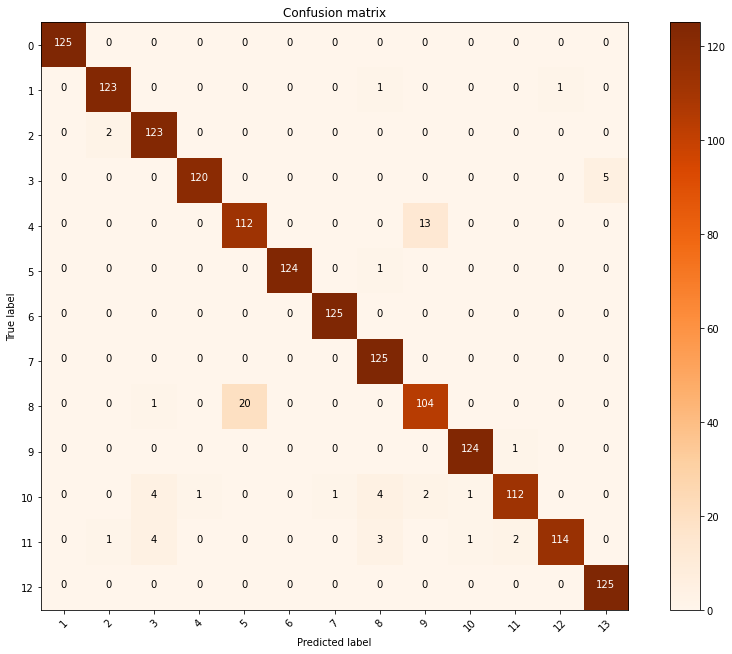

---->  Results with training size 50 percent
0.9575384615384616


In [ ]:


def save_training_results(dataset, trainSize, fold_number, model_name, TrainedModel,  y_prob3,y_prob4):
    DS = 'dataset%i_' %dataset
    fname = 'trainSize%i' %trainSize
    fname_with_path = '/content/gdrive/My Drive/RS_results/' +DS +  'best_'+ model_name + '_'+ fname+'_fold'+str(fold_number)
    model_json = TrainedModel.to_json()
    with open(fname_with_path+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    TrainedModel.save_weights(fname_with_path+".h5")
    print("Saved model to disk: ", fname_with_path)

    DS = 'dataset%i_' %dataset
    fname = 'trainSize%i' %trainSize
    fname_with_path = '/content/gdrive/My Drive/RS_results/' + DS + 'res_' + model_name + '_'+ fname+'_fold'+str(fold_number)
    D = {'y_prob3': y_prob3, 'y_prob4': y_prob4}
    np.savez(fname_with_path, **D)
    print("Saved results to disk: ", fname_with_path)

for i in range(1):
  i = i+2
  if i==0:
      ##########################################################################
      #  fold_number = 0 or 1 means train on one fold of the training set
      fold_number = 0;   
      train_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=training_folds[ :split_location    ])
      test_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=training_folds[ split_location:   ])
      ##########################################################################
  elif i==1:
      ##########################################################################
      #  fold_number = 0 or 1 means train on one fold of the training set
      fold_number = 1;   
      test_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=training_folds[ :split_location    ])
      train_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=training_folds[ split_location:   ])      
      ##########################################################################
  else:
      ##########################################################################
      #  fold_number = 99 means train on all 80% of the data
      fold_number = 99;   
      train_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=training_folds)
      test_samples = get_samples(fold_splits_indeces , fold_splits_labels , list_of_folds=testing_folds)       
      ##########################################################################

  print('Training folds : ' , training_folds); print('Testing folds : ' , testing_folds); 

  print('train_samples: ', train_samples.shape)
  # print('val_samples: ', validation_samples.shape)
  print('test_samples: ', test_samples.shape)

  X_train =  X[train_samples[0]  ].copy()
  Y_train =  y[train_samples[0]  ].copy()
  Y_train =  np_utils.to_categorical(Y_train  ,   num_classes=num_classes)
  X_test =  X[test_samples[0]  ].copy()
  y_test =  y[test_samples[0]  ].copy()
  print("X_train  shape", X_train.shape)
  print("Y_train  shape", Y_train.shape)
  print("X_test  shape", X_test.shape)
  print("y_test  shape", y_test.shape)


  t1 = time.time()

  # X_train = preprocess_input(X_train.astype(np.float32))
  # X_test = preprocess_input(X_test.astype(np.float32))
  # TrainedModel, history_Model1 = build_and_train_VGG16(img_dim, num_classes , X_train, Y_train)
  # y_prob4 = TrainedModel.predict(X_test, batch_size = 32) 
  # y_prob3 = y_prob4.copy()        
  # save_training_results(dataset, trainSize, fold_number, 'VGG16', TrainedModel, y_prob3,y_prob4)

  # X_train = densenet.preprocess_input(X_train.astype(np.float32))
  # X_test = densenet.preprocess_input(X_test.astype(np.float32))
  # TrainedModel, history_Model1 = build_and_train_densenet(img_dim, num_classes , X_train, Y_train)
  # [y_prob3,y_prob4] = TrainedModel.predict(X_test, batch_size = 32)           
  # save_training_results(dataset, trainSize, fold_number, 'Densenet', TrainedModel, y_prob3,y_prob4)

  X_train = inception_v3.preprocess_input(X_train.astype(np.float32))
  X_test = inception_v3.preprocess_input(X_test.astype(np.float32))
  TrainedModel, history_Model1 = build_and_train_InceptionV3(img_dim, num_classes , X_train, Y_train)
  [y_prob3,y_prob4] = TrainedModel.predict(X_test, batch_size = 32)           
  save_training_results(dataset, trainSize, fold_number, 'InceptionV3', TrainedModel, y_prob3,y_prob4)

  # X_train = inception_resnet_v2.preprocess_input(X_train.astype(np.float32))
  # X_test = inception_resnet_v2.preprocess_input(X_test.astype(np.float32))
  # TrainedModel, history_Model1 = build_and_train_Inception_resnet_v2(img_dim, num_classes , X_train, Y_train)
  # [y_prob3,y_prob4] = TrainedModel.predict(X_test, batch_size = 32)           
  # save_training_results(dataset, trainSize, fold_number, 'Inception_resnet_v2', TrainedModel, y_prob3,y_prob4)

  # X_train = efficientnet.preprocess_input(X_train.astype(np.float32))
  # X_test = efficientnet.preprocess_input(X_test.astype(np.float32))
  # TrainedModel, history_Model1 = build_and_train_efficientnetB3(img_dim, num_classes , X_train, Y_train)
  # [y_prob3,y_prob4] = TrainedModel.predict(X_test, batch_size = 32)           
  # save_training_results(dataset, trainSize, fold_number,'efficientnetB3', TrainedModel, y_prob3,y_prob4)

  Test_predicted = np.argmax(y_prob4, axis=1)
  cm_after_adaptation = confusion_matrix(y_test, Test_predicted)
  OA_final = accuracy_score(y_test,Test_predicted)
  print('---->  Results with training size %i percent' % trainSize)
  print(OA_final)

  cnf_matrix =confusion_matrix(y_test,Test_predicted)
  np.set_printoptions(precision=1) 
  print('Confusion matrix, without normalization')
  plt.figure(figsize = (12,9))
  plot_confusion_matrix2(cnf_matrix)
  #plot_confusion_matrix1(cnf_matrix, classes,  normalize=False, cmap=plt.cm.Blues)
  plt.show()

  print('---->  Results with training size %i percent' % trainSize)
  print(OA_final)


---->  Results with training size 80 percent
0.995
Confusion matrix, without normalization


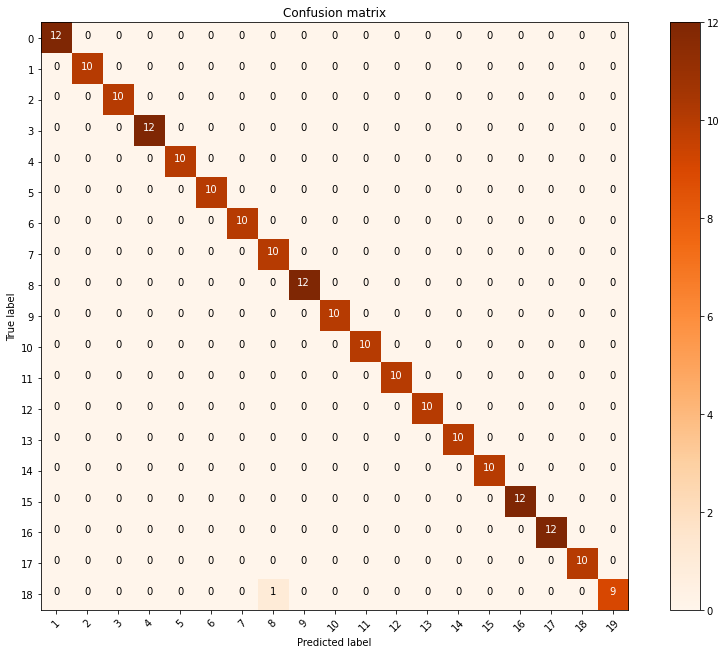

---->  Results with training size 80 percent
0.995


In [ ]:

Test_predicted = np.argmax(y_prob4, axis=1)
cm_after_adaptation = confusion_matrix(y_test, Test_predicted)
OA_final = accuracy_score(y_test,Test_predicted)
print('---->  Results with training size %i percent' % trainSize)
print(OA_final)


cnf_matrix =confusion_matrix(y_test,Test_predicted)
np.set_printoptions(precision=1) 
print('Confusion matrix, without normalization')
plt.figure(figsize = (12,9))
plot_confusion_matrix2(cnf_matrix)
#plot_confusion_matrix1(cnf_matrix, classes,  normalize=False, cmap=plt.cm.Blues)
plt.show()



print('---->  Results with training size %i percent' % trainSize)
print(OA_final)


[Loss : 0.002 ] Time 263.3881320953369


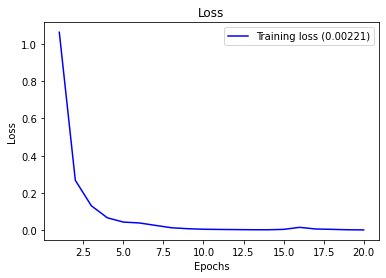

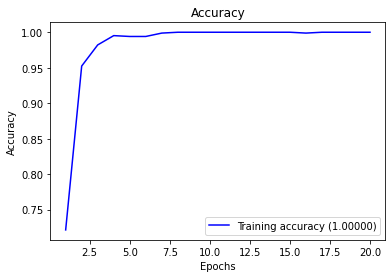

Confusion matrix, without normalization


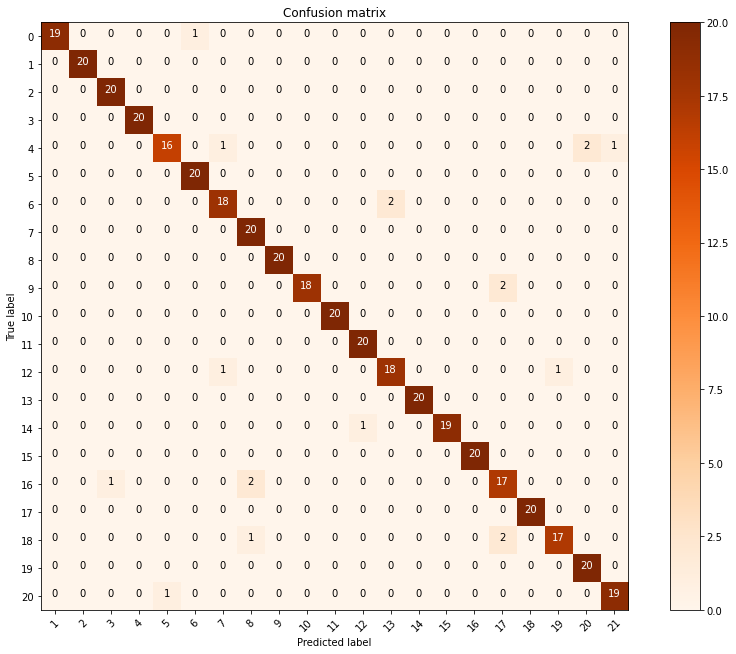

In [ ]:

history = history_Model1
loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
losses = history.history[loss_list[0]]
print('\n[Loss : {:.3f} ] Time'.format(losses[-1:][0]), time.time() - t1)
plot_history(history)


cnf_matrix =confusion_matrix(y_test,Test_predicted)
np.set_printoptions(precision=1) 
print('Confusion matrix, without normalization')
plt.figure(figsize = (12,9))
plot_confusion_matrix2(cnf_matrix)
#plot_confusion_matrix1(cnf_matrix, classes,  normalize=False, cmap=plt.cm.Blues)
plt.show()



